# Let's quickly pull the data and make it able to export the data to the model.

In [139]:
# modules.

try:
    
    import math
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib.pylab as plt
    from sklearn.ensemble import RandomForestRegressor
    from IPython.display import display
    from sklearn import metrics
    from sklearn import tree
    import re
    from pandas.api.types import is_string_dtype
    from pandas.api.types import is_numeric_dtype
    import scipy
    from scipy.cluster import hierarchy as hc
    from pdpbox import pdp
    from plotnine import *
    from treeinterpreter import treeinterpreter as ti

    
except:
    
    !pip3 install -r requirements.txt
    
    print("Run this cell again")

In [114]:
# Test and training set.

train = pd.read_csv("train-data.csv")
test = pd.read_csv("test-data.csv")

In [115]:
# We took the logarithm for the RMSE.

train["Price"] = np.log(train.Price)
test["Price"] = np.log(test.Price)
train.head()

,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,Price,Mileage,Mileage_naa,Engine,Engine_naa,Power,Power_naa
0,2010,72000,CNG,Manual,First,5.0,0.559616,11.308823,False,998.0,False,58.16,False
1,2015,41000,Diesel,Manual,First,5.0,2.525729,19.670000,False,1582.0,False,126.20,False
2,2011,46000,Petrol,Manual,First,5.0,1.504077,18.200000,False,1199.0,False,88.70,False
3,2012,87000,Diesel,Manual,First,7.0,1.791759,20.770000,False,1248.0,False,88.76,False
4,2013,40670,Diesel,Automatic,Second,5.0,2.875822,15.200000,False,1968.0,False,140.80,False


In [116]:
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c):
            df[n] = c.astype("category").cat.as_ordered()
            
def apply_cats(df, train):
    for n, c in df.items():
        if train[n].dtype == "category":
            df[n] = pd.Categorical(c, categories = train[n].cat.categories, ordered = True)

In [117]:
train_cats(test)
train_cats(train)

In [118]:
print(train["Fuel_Type"].cat.categories)
print(test["Fuel_Type"].cat.categories)
 
print(train["Transmission"].cat.categories)
print(test["Transmission"].cat.categories)

print(train["Owner_Type"].cat.categories)
print(test["Owner_Type"].cat.categories)

Index(['CNG', 'Diesel', 'Electric', 'LPG', 'Petrol'], dtype='object')
Index(['CNG', 'Diesel', 'LPG', 'Petrol'], dtype='object')
Index(['Automatic', 'Manual'], dtype='object')
Index(['Automatic', 'Manual'], dtype='object')
Index(['First', 'Fourth & Above', 'Second', 'Third'], dtype='object')
Index(['First', 'Fourth & Above', 'Second', 'Third'], dtype='object')


In [119]:
train["Fuel_Type"].cat.set_categories(['CNG', 'Diesel', 'Electric', 'LPG', 'Petrol'], ordered = True, inplace = True)
test["Fuel_Type"].cat.set_categories(['CNG', 'Diesel', 'Electric', 'LPG', 'Petrol'], ordered = True, inplace = True)

train["Transmission"].cat.set_categories(['Automatic', 'Manual'], ordered = True, inplace = True)
test["Transmission"].cat.set_categories(['Automatic', 'Manual'], ordered = True, inplace = True)

train["Owner_Type"].cat.set_categories(['First', 'Fourth & Above', 'Second', 'Third'], ordered = True, inplace = True)
test["Owner_Type"].cat.set_categories(['First', 'Fourth & Above', 'Second', 'Third'], ordered = True, inplace = True)

In [120]:
def fix_missing(df, col, name):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum:
            df[name+"_na"] = pd.isnull(col)
        df[name] = col.fillna(col.median())
        
def numericalize(df, col, name):
    if not is_numeric_dtype(col):
        df[name] = col.cat.codes+1
        
def proc_df(df, y_fld):
    
    y = df[y_fld].values
    df.drop([y_fld], axis = 1, inplace = True)
    
    for n, c in df.items():
        fix_missing(df, c, n)
        numericalize(df, c, n)
    
    res = [df, y]
    
    return res

In [121]:
train, y_train = proc_df(train, 'Price')
test, y_test = proc_df(test, 'Price')

In [122]:
print(len(y_train))
print(len(train))

for i in train.columns:
    
    a = i + "{}".format("_na")
    
    try:
    
        train.drop([a],axis=1,inplace = True)
        test.drop([a],axis=1,inplace = True)
        
    except:
        
        pass
    
train.head()

4991
4991


,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,Mileage,Mileage_naa,Engine,Engine_naa,Power,Power_naa
0,2010,72000,1,2,1,5.0,11.308823,False,998.0,False,58.16,False
1,2015,41000,2,2,1,5.0,19.670000,False,1582.0,False,126.20,False
2,2011,46000,5,2,1,5.0,18.200000,False,1199.0,False,88.70,False
3,2012,87000,2,2,1,7.0,20.770000,False,1248.0,False,88.76,False
4,2013,40670,2,1,3,5.0,15.200000,False,1968.0,False,140.80,False


In [123]:
def split_train_val(df,n): 
    
    return df[:n].copy(), df[n:].copy()

n_valid = 2000
n_train = len(train)-n_valid

train, validation = split_train_val(train, n_train)
y_train, y_validation = split_train_val(y_train, n_train)

In [124]:
# Our evaluation metric.

def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

In [125]:
def print_score(m):
    
    print(f"RMSE of train set {rmse(m.predict(train), y_train)}")
    print(f"RMSE of validation set {rmse(m.predict(validation), y_validation)}")
    print(f"R^2 of train set {m.score(train, y_train)}")
    print(f"R^2 of validation set {m.score(validation, y_validation)}")
    if hasattr(m, "oob_score_"):
        print(f"OOB score: {m.oob_score_}")

In [126]:
# final model
m = RandomForestRegressor(n_estimators=120, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(train, y_train)
print_score(m)

CPU times: user 968 ms, sys: 37.5 ms, total: 1.01 s
Wall time: 326 ms
RMSE of train set 0.09172010544122929
RMSE of validation set 0.2614329217951862
R^2 of train set 0.9893260314308356
R^2 of validation set 0.9059358295303424
OOB score: 0.9207075651656126


# Partial dependence

A partial dependence (PD) plot depicts the functional relationship between a small number of input variables and predictions. They show how the predictions partially depend on values of the input variables of interest.  For example, a PD plot can show whether the probability of flu increases linearly with fever. It can show whether high energy level will decrease the probability of having flu. PD can also show the type of relationship, such as a step function, curvilinear, linear and so on.

The simplest PD plots are 1-way plots, which show how a model’s predictions depend on a single input.

In [127]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, train, train.columns, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

In [128]:
train.columns

Index(['Year', 'Kilometers_Driven', 'Fuel_Type', 'Transmission', 'Owner_Type',
       'Seats', 'Mileage', 'Mileage_naa', 'Engine', 'Engine_naa', 'Power',
       'Power_naa'],
      dtype='object')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <AxesSubplot:>, 'pdp_ax': <AxesSubplot:xlabel='Year'>})

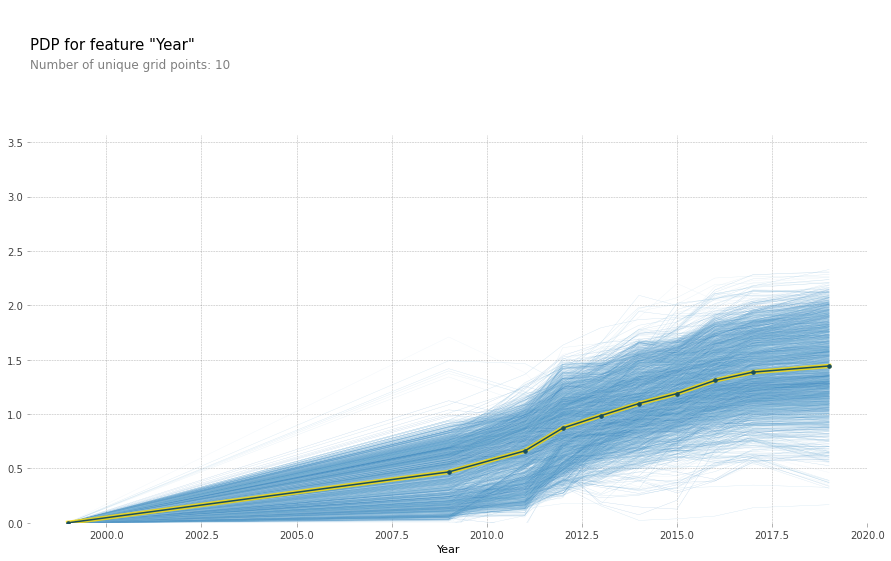

In [129]:
plot_pdp('Year')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <AxesSubplot:>, 'pdp_ax': <AxesSubplot:xlabel='Power'>})

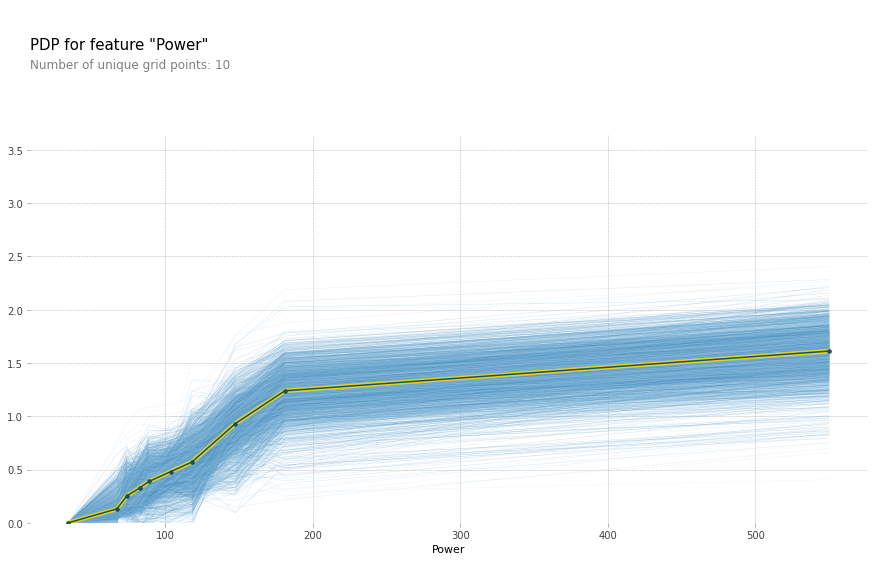

In [130]:
plot_pdp('Power')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <AxesSubplot:>, 'pdp_ax': <AxesSubplot:xlabel='Engine'>})

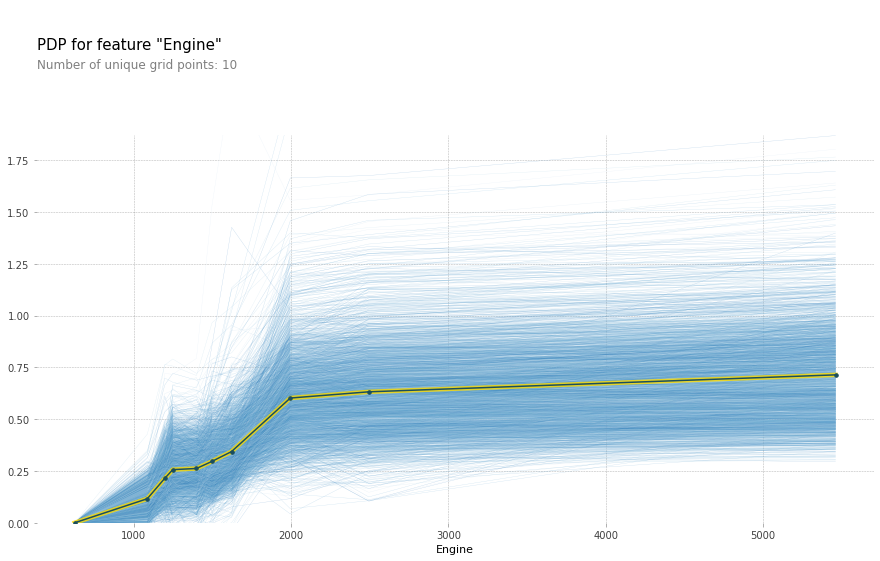

In [131]:
plot_pdp('Engine')

**It is observed that the graphics increase the price of new and powerful vehicles.**

## Partial Dependence of Categorical Variables

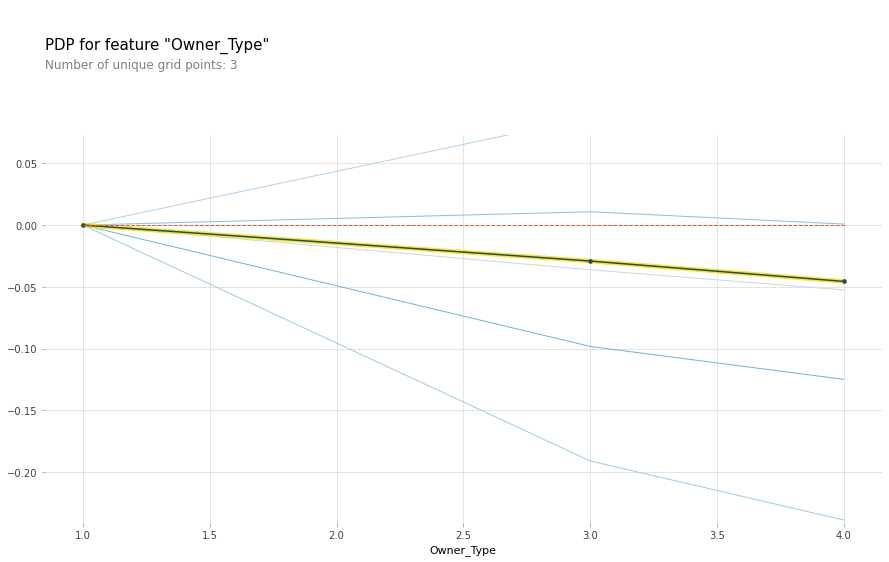

In [132]:
plot_pdp('Owner_Type', clusters=5);

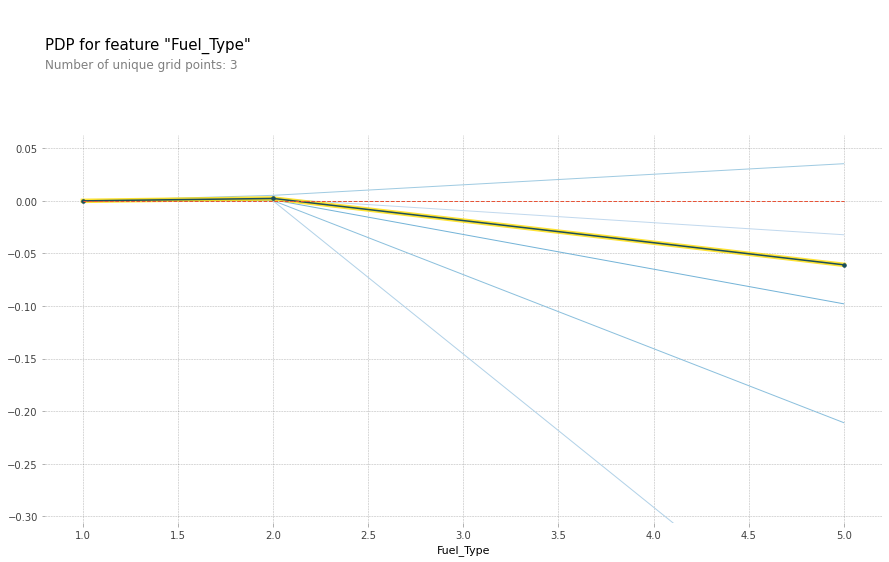

In [133]:
plot_pdp('Fuel_Type', clusters=5);

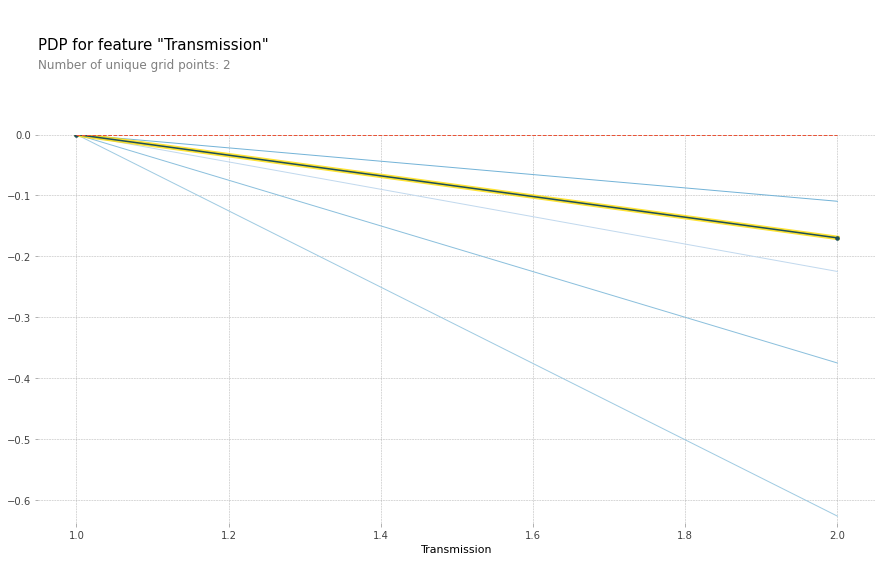

In [134]:
plot_pdp('Transmission', clusters=5);

# Tree interpreter

Package for interpreting scikit-learn’s decision tree and random forest predictions. Allows decomposing each prediction into bias and feature contribution components as described in http://blog.datadive.net/interpreting-random-forests/. For a dataset with n features, each prediction on the dataset is decomposed as prediction = bias + feature_1_contribution + ... + feature_n_contribution.

It works on scikit-learn’s

    DecisionTreeRegressor
    DecisionTreeClassifier
    ExtraTreeRegressor
    ExtraTreeClassifier
    RandomForestRegressor
    RandomForestClassifier
    ExtraTreesRegressor
    ExtraTreesClassifier

In [140]:
validation.values

array([[2008, 66000, 5, ..., False, 46.3, False],
       [2010, 55324, 5, ..., False, 66.1, False],
       [2009, 90000, 2, ..., False, 235.0, False],
       ...,
       [2016, 27000, 2, ..., False, 265.0, False],
       [2016, 39000, 2, ..., False, 143.0, False],
       [2015, 131000, 2, ..., False, 74.0, False]], dtype=object)

In [141]:
validation.values.shape

(2000, 12)

In [142]:
row = validation.values[None,0]; row

array([[2008, 66000, 5, 2, 1, 5.0, 19.7, False, 796.0, False, 46.3,
        False]], dtype=object)

In [143]:
prediction, bias, contributions = ti.predict(m, row)

In [144]:
# second one is the avr sale price across the dataset (base model,first node's prediction)
prediction[0], bias[0]

(array([0.40001708]), 1.842145416257717)

In [145]:
contributions.shape

(1, 12)

In [146]:
idxs = np.argsort(contributions[0])

In [147]:
idxs

array([10,  0,  8,  3,  2,  7,  9, 11,  6,  5,  4,  1])

In [148]:
[o for o in zip(validation.columns[idxs], validation.iloc[0][idxs], contributions[0][idxs])]

[('Power', 46.3, -0.5735032338654812),
 ('Year', 2008, -0.5571081014501427),
 ('Engine', 796.0, -0.3876570201647115),
 ('Transmission', 2, -0.04914481768799579),
 ('Fuel_Type', 5, -0.017346643293603168),
 ('Mileage_naa', False, 0.0),
 ('Engine_naa', False, 0.0),
 ('Power_naa', False, 0.0),
 ('Mileage', 19.7, 0.022872536352243525),
 ('Seats', 5.0, 0.03292408078250435),
 ('Owner_Type', 1, 0.03778045343901635),
 ('Kilometers_Driven', 66000, 0.04905440640091783)]

In [149]:
contributions[0].sum()

-1.4421283394872524

In [153]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'columns':df.columns, 'importance':m.feature_importances_}
                       ).sort_values('importance', ascending=False)
def plot_feature_importance(fi): 
    return fi.plot('columns', 'importance', 'barh', figsize=(12,7), legend=False)

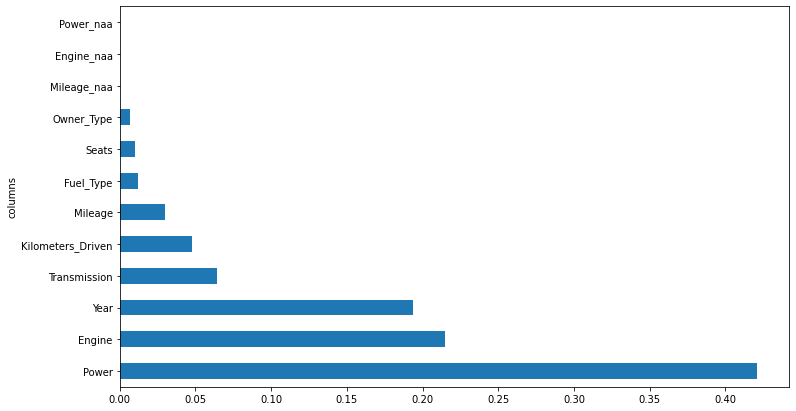

In [154]:
plot_feature_importance(rf_feat_importance(m, test));

**I have commented that Power_naa, Engine_naa and Mileafe_naa are added to no avail.**
**I will check if these columns have a value of true.**
**Apparently there was no _na value in the columns and we opened the column for checking _na to no avail.**

In [159]:
for i in train.Power_naa:
    
    if i == "True":
        
        print("yes")
        
    if i == True:
        
        print("yes")

In [160]:
for i in test.Power_naa:
    
    if i == "True":
        
        print("yes")
        
    if i == True:
        
        print("yes")

In [161]:
for i in train.Engine_naa:
    
    if i == "True":
        
        print("yes")
        
    if i == True:
        
        print("yes")

In [163]:
for i in test.Engine_naa:
    
    if i == "True":
        
        print("yes")
        
    if i == True:
        
        print("yes")

In [164]:
lis = ["Power_naa", "Engine_naa", "Mileage_naa"]

for i in lis:

    train.drop([i],axis=1,inplace = True)
    test.drop([i],axis=1,inplace = True)
    validation.drop([i],axis=1,inplace = True)

In [166]:
train.head()

,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,Mileage,Engine,Power
0,2010,72000,1,2,1,5.0,11.308823,998.0,58.16
1,2015,41000,2,2,1,5.0,19.670000,1582.0,126.20
2,2011,46000,5,2,1,5.0,18.200000,1199.0,88.70
3,2012,87000,2,2,1,7.0,20.770000,1248.0,88.76
4,2013,40670,2,1,3,5.0,15.200000,1968.0,140.80


**New model and results**

In [167]:
# final model
m = RandomForestRegressor(n_estimators=120, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(train, y_train)
print_score(m)

CPU times: user 1.99 s, sys: 62.7 ms, total: 2.05 s
Wall time: 694 ms
RMSE of train set 0.0912733618585027
RMSE of validation set 0.25931432205561433
R^2 of train set 0.989429758173002
R^2 of validation set 0.9074542063718982
OOB score: 0.9210447090380429


In [168]:
# Test

print(f"RMSE of test set {rmse(m.predict(test), y_test)}")
print(f"R^2 of test set {m.score(test, y_test)}")

RMSE of test set 0.23609716867131028
R^2 of test set 0.9270391095628056


**Old model and results**

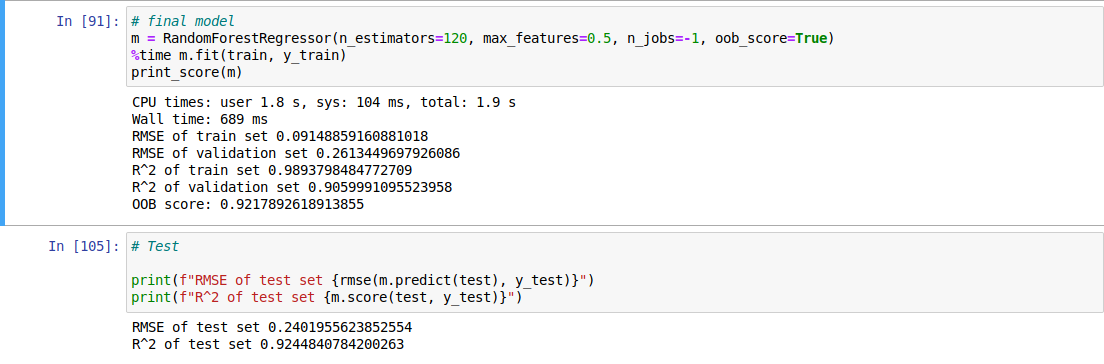